# **MCBS - Final Project** 
## Data pree-processing for Model 2

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import io

#from vis.utils import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
#from scipy.misc import imsave
from skimage import io
#import residual_network

import sys
import shutil
import os.path

Using TensorFlow backend.


In [2]:
OVERWRITE = True

In [9]:
def create_directory(directory):
    if os.path.exists(directory):
        if OVERWRITE:
            shutil.rmtree(directory)
            os.mkdir(directory)
    else:
        os.mkdir(directory)

In [4]:
classes_dictionary_org = {'BAS':0, 'EBO':1, 'EOS':2, 'KSC':3, 'LYA':4, 'LYT':5, 'MMZ':6, 'MOB':7, 'MON':8, 'MYB':9, 'MYO':10, 'NGB':11, 'NGS':12, 'PMB':13, 'PMO':14 }
classes_dictionary = {value: key for key, value in classes_dictionary_org.items()}

abbreviation_dict = { 'NGS':'Neutrophil (segmented)', 
                      'NGB':'Neutrophil (band)',
                      'EOS':'Eosinophil',
                      'BAS':'Basophil',
                      'MON':'Monocyte',
                      'LYT':'Lymphocyte (typical)',
                      'LYA':'Lymphocyte (atypical)',
                      'KSC':'Smudge Cell',
                      'MYO':'Myeloblast',
                      'PMO':'Promyelocyte',
                      'MYB':'Myelocyte',
                      'MMZ':'Metamyelocyte',
                      'MOB':'Monoblast',
                      'EBO':'Erythroblast',
                      'PMB':'Promyelocyte (bilobed)'};

def get_label(probabilities):
    return abbreviation_dict[classes_dictionary[np.argmax(probabilities)]]

In [5]:
img_width, img_height = 400, 400

if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
else:
        input_shape = (img_width, img_height, 3)

Loading the original model from 

In [9]:
weight_file_path = "weights.hdf5"

model = residual_network.model
model.load_weights(weight_file_path)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
base_path = "../data/aml"
orig_data_path  = f"{base_path}/full"
data_path = f"{base_path}/full"
split_data_path = f"{base_path}/split"

annotation_file = "./data_orig/AML-Cytomorphology/annotations.dat"

In [187]:
annot = pd.read_table(annotation_file, sep=' ', header=None)
annot.columns = ['Filepath', 'Label', 'Re-annotation', 'Re-annotation (11 months)']
annot.head()

,Filepath,Label,Re-annotation,Re-annotation (11 months)
0,BAS/BAS_0001.tiff,BAS,NaN,NaN
1,BAS/BAS_0002.tiff,BAS,NaN,NaN
2,BAS/BAS_0003.tiff,BAS,NaN,NaN
3,BAS/BAS_0004.tiff,BAS,NaN,NaN
4,BAS/BAS_0005.tiff,BAS,NaN,NaN


In [7]:
def save_to_png(filepath, new_filepath):
    img = io.imread(filepath)
    img = img[:,:,:3]
    io.imsave(new_filepath, img)

def convert_from_tiff(orig_dir, new_dir):
    
    create_directory(new_dir)

    for subdir, dirs, files in os.walk(orig_dir):
        if not dirs:
            print(f"Processing {subdir}.")
            new_subdir = os.path.join(new_dir, subdir.split("/")[-1])
            create_directory(new_subdir)

            for file in files:
                if file.endswith('.tiff'):
                    filename = file.split(".")[0]
                    filepath = os.path.join(subdir, file)
                    new_filepath = os.path.join(new_subdir, ".".join([filename, "png"]))
                    save_to_png(filepath, new_filepath)

In [198]:
convert_from_tiff(orig_data_path, data_path)

Processing ./data_orig/AML-Cytomorphology/MYO.


In [12]:
import splitfolders

create_directory(split_data_path)

create_directory(f'{split_data_path}/train')
create_directory(f'{split_data_path}/test')
create_directory(f'{split_data_path}/val')

splitfolders.ratio(data_path, output=split_data_path, seed=1234, ratio=(.8,.1,.1)) 

Copying files: 18365 files [00:05, 3534.63 files/s]


In [16]:
def get_number_of_files(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

def augment_data(directory, new_directory, abbv = "IMG", num_files_goal = 10000):
    
    new_subdirectory = os.path.join(new_directory, directory.split("/")[-1])
    
    print(f"Processing {directory}, augmented data will be saved to {new_subdirectory}.")
    shutil.copytree(directory, new_subdirectory)
    
    datagen = ImageDataGenerator(rotation_range=359,
                                  width_shift_range=0.2,  
                                  height_shift_range=0.2,    
                                  shear_range=0.2,        
                                  zoom_range=0.2,        
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')

    images = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    num_files = len(images)
    
    while get_number_of_files(new_subdirectory) < num_files_goal:
        num_files = get_number_of_files(new_subdirectory)
        
        while num_files < num_files_goal:
            file = random.choice(images)
            img = load_img(file)  
            x = img_to_array(img) 
            x = x.reshape((1, ) + x.shape)  
            i = 0

            # generate and save
            for batch in datagen.flow(x, batch_size = 1, 
                                        save_to_dir = new_subdirectory,  
                                        save_prefix =f'AUG_{abbv}',
                                        save_format ='png'):
                i += 1
                num_files += 1
                
                if i >= 20: 
                    break

    print(f"Number of files after augmentation: {get_number_of_files(new_subdirectory)}")

In [17]:
aug_data_path = f"{split_data_path}/train_aug10k/"

create_directory(aug_data_path)

num_of_imgs = 10000

for abbv in abbreviation_dict:
    augment_data(f"{split_data_path}/train/{abbv}", aug_data_path, abbv, num_of_imgs)

Processing ../data/aml/split/train/NGS, augmented data will be saved to ../data/aml/split/train_aug10k/NGS.
Number of files after augmentation: 10007
Processing ../data/aml/split/train/NGB, augmented data will be saved to ../data/aml/split/train_aug10k/NGB.
Number of files after augmentation: 10000
Processing ../data/aml/split/train/EOS, augmented data will be saved to ../data/aml/split/train_aug10k/EOS.
Number of files after augmentation: 10000
Processing ../data/aml/split/train/BAS, augmented data will be saved to ../data/aml/split/train_aug10k/BAS.
Number of files after augmentation: 10000
Processing ../data/aml/split/train/MON, augmented data will be saved to ../data/aml/split/train_aug10k/MON.
Number of files after augmentation: 10000
Processing ../data/aml/split/train/LYT, augmented data will be saved to ../data/aml/split/train_aug10k/LYT.
Number of files after augmentation: 10008
Processing ../data/aml/split/train/LYA, augmented data will be saved to ../data/aml/split/train_aug1

FileExistsError: [Errno 17] File exists: '../data/aml/split/train_aug10k/MMZ'

In [200]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255,
                            validation_split=0.2)

test_set = datagen.flow_from_directory(data_path,
                                    class_mode = 'categorical', 
                                    target_size = (img_width, img_height),
                                    subset="validation",
                                    batch_size = 16, 
                                    shuffle=True)


Found 3667 images belonging to 16 classes.


In [151]:
x, y = test_set.next()

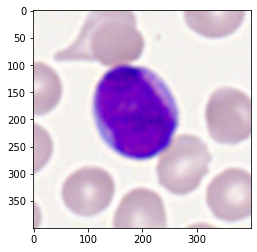

In [152]:
plt.imshow(x[2,:,:,:])

In [201]:
x_test, y_test = test_set.next()
y_pred = model.predict(x_test).argmax(axis=1)

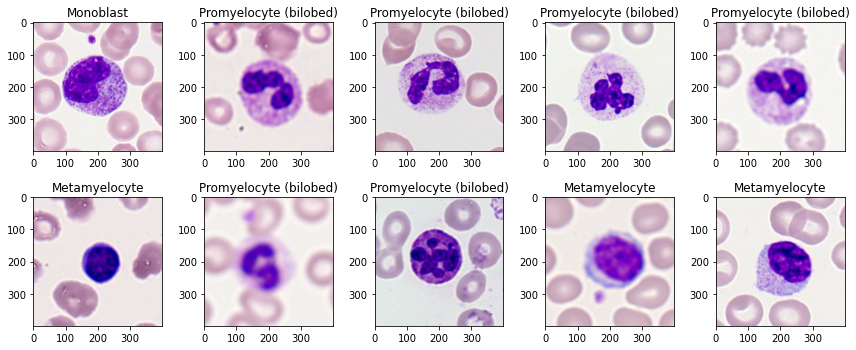

In [202]:
fig, axs = plt.subplots(2,5, figsize=(12,5))
fig.tight_layout() 

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(abbreviation_dict[classes_dictionary[y_test.argmax(axis=1)[i]]])
    plt.imshow(x_test[i,:,:,:])

In [203]:
test_loss, test_acc = model.evaluate(test_set)

230/230 [==============================] - 75s 325ms/step - loss: 12.3344 - accuracy: 8.1811e-04


In [204]:
weight_file_path = "weights.hdf5"

model = residual_network.model
model.load_weights(weight_file_path)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
#test_loss, test_acc = model.evaluate(test_set)

In [205]:
y_pred = model.predict(test_set).argmax(axis=1)
y_test = test_set.classes

AttributeError: module 'matplotlib.pyplot' has no attribute 'y_labels'

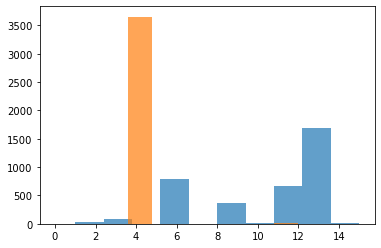

In [214]:
plt.hist(test_set.classes, alpha=0.7)
plt.hist(y_pred, alpha=0.7)
plt.y_labels([abbreviation_dict[classes_dictionary[i]] for i in range(14)])
plt.legend(['True','Predicted'])

In [ ]:
print(y_pred[:10],"\n", y_test[:10])

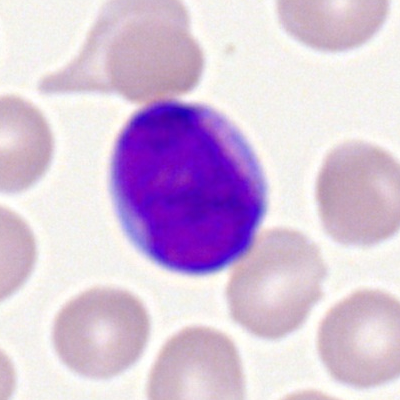

In [39]:
image.array_to_img(img)

In [124]:
img_filepath  = f"{data_path}/MYO/MYO_0011.png"
img = io.imread(img_filepath)
img = (img*1./255)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

Network output distribution: 
----------------------------------------------
Basophil                   3.518518e-05
Erythroblast               2.120058e-09
Eosinophil                 6.9941625e-06
Smudge Cell                0.99936134
Lymphocyte (atypical)      8.684655e-05
Lymphocyte (typical)       4.5700926e-07
Metamyelocyte              0.00010706867
Monoblast                  1.4579158e-05
Monocyte                   0.0001715416
Myelocyte                  1.946494e-06
Myeloblast                 0.0002113752
Neutrophil (band)          6.001968e-08
Neutrophil (segmented)     1.1082648e-06
Promyelocyte (bilobed)     6.28344e-11
Promyelocyte               1.4631802e-06


PREDICTION: 
Smudge Cell


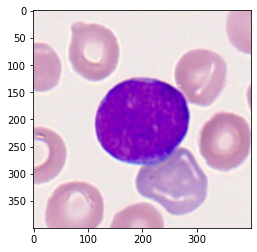

In [132]:
images = np.vstack([x])
preds_probs = model.predict(images, batch_size=1)
img_filepath  = f"{orig_data_path}/MYO/MYO_0002.tiff"
img = io.imread(img_filepath)
img = (img[:,:,:3] *1./255)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.imshow(image.array_to_img(img))

# for i in range(len(preds_probs[0])):
# 	print('{0:25}  {1}'.format(i, str(preds_probs[0][i])))

preds_probs = np.array(preds_probs)
preds_probs[:,1]+=preds_probs[:,2]
preds_probs=np.delete(preds_probs,2,1)

print ("Network output distribution: \n----------------------------------------------")
for i in range(len(preds_probs[0])):
	print('{0:25}  {1}'.format(abbreviation_dict[classes_dictionary[i]], str(preds_probs[0][i])))

print ("\n\nPREDICTION: \n"+abbreviation_dict[classes_dictionary[np.argmax(preds_probs)]])
        